# __Prediction of the price of wine__

<img src="img/Bandeau.jpeg" alt="Girl in a jacket" width="1200" height="600" > 

Authors : *David Admète, Guillaume Bril, Célian Charleau, Hubert de Lesquen,Ruben Didier, Alexandre Gommez.*

## Introduction 

The objective of this project is to determine the value of a bottle of wine according to many factors such as the producer, the year or the appellation.

Indeed, the wine market in France represents nearly 30 billion euros. And the export market is worth 12.7 billion euros, the second largest contributor to the balance of trade behind aeronautics.

Predicting prices will allow wine growers to better manage their operations and to perpetuate them over time.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import plotly.express as px
from collections import Counter
import re
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import category_encoders as ce

In [2]:
from sklearn import set_config
set_config(display='diagram')

In [3]:
!python data_loader.py

# Challenge.

The goal of this challenge is to predict the average price of a wine bottle

# Data presentation.

The data is composed of the file `train.csv` which contains a list of wines with many features.

In [4]:
df_train = pd.read_csv('data/train.csv', sep=';', encoding='utf-8')
df_train.head()

,vin,cuvee,millesime,guide,note,classement,region,appellation,type,prix,...,prod_id,adresse,CP,commune,pays,INSEE_COM,INSEE_DEP,INSEE_REG,lon,lat
0,CHÂTEAU MOUSSEYRON,NaN,2008.0,Guide 2010,1,NaN,Bordelais,Bordeaux blanc,Blanc tranquille,- de 5 €,...,13733.0,"31, rte de Gaillard",33490.0,Saint-Pierre-d'Aurillac,France,33463,33,75.0,-0.190335,44.572379
1,CHÂTEAU HAUT CORBIAN,NaN,2014.0,Guide 2018,1,NaN,Bordelais,Saint-estèphe,Rouge tranquille,11 à 15 €,...,48920.0,"16, rte du Vieux-Moulin Saint-Corbian",33180.0,Saint-Estèphe,France,33395,33,75.0,-0.772464,45.259352
2,DOMAINE BELLE,NaN,2010.0,Guide 2014,0,NaN,Vallée du Rhône,Hermitage,Rouge tranquille,30 à 50 €,...,49569.0,"510, rue de la Croix",26600.0,Larnage,France,26156,26,84.0,4.862945,45.097200
3,COUVREUR-PHILIPPART,Carte d'or,NaN,Guide 2016,1,1er cru,Champagne,Champagne,Blanc effervescent,11 à 15 €,...,67163.0,"12, rue de Reims",51500.0,Rilly-la-Montagne,France,51461,51,44.0,4.044316,49.165048
4,DOMAINE MADELOC,Serrail,2011.0,Guide 2015,2,NaN,Roussillon,Collioure,Rouge tranquille,11 à 15 €,...,48072.0,"1 bis, av. du Gal-de-Gaulle",66650.0,Banyuls-sur-Mer,France,66016,66,76.0,3.129439,42.481151


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113718 entries, 0 to 113717
Data columns (total 29 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           113718 non-null  object 
 1   cuvee         69071 non-null   object 
 2   millesime     105432 non-null  float64
 3   guide         113718 non-null  object 
 4   note          113718 non-null  int64  
 5   classement    12525 non-null   object 
 6   region        113718 non-null  object 
 7   appellation   113718 non-null  object 
 8   type          113718 non-null  object 
 9   prix          113718 non-null  object 
 10  prix_min      102741 non-null  float64
 11  prix_max      111701 non-null  float64
 12  prix_m        113718 non-null  float64
 13  consommation  35760 non-null   object 
 14  commentaire   109919 non-null  object 
 15  garde         35761 non-null   object 
 16  production    113718 non-null  int64  
 17  elevage       113718 non-null  object 
 18  prod

The training set contains 113 718 wines with those different features:
- 'vin': wine name,
- 'cuvee'
- 'millesime': wine vintage,
- 'guide': Hachette wine guide vintage of the evaluation,
- 'note': wine score according Hachette wine guide (from 0 to 3). Unknown scores are also noted as 0.
- 'classement': wine classification,
- 'region': production region,
- 'appellation',
- 'type',
- 'consommation': comment concerning wine consumption (delay before drink a bottle),
- 'commentaire': comment one wine's quality,
- 'garde': when filled, conservation duration,
- 'production': the number of bottles produced for this wine,
- 'elevage': the way the wine grew (barrel, tank...)
- 'producteur': producer's name
- 'prod_id': producer's identification number,
- 'adresse': producer's address,
- 'CP': postal zip code,
- 'commune': city,
- 'pays': country,
- 'INSEE_COM': administrative zip code,
- 'INSEE_DEP': department administrative zip code,
- 'INSEE_REG': region administrative zip code,
- 'lon': geographic coordinate - longitude
- 'la': geographic coordinate - latitude

And also:
- 'prix': price range,
- 'prix_min': minimum price,
- 'prix_max': maximum price,
- 'prix_m': average price.

We create a feature with the price quartile the wine belongs to.

In [6]:
df_train['prix_q'] = pd.qcut(df_train['prix_m'], 4, labels=False)

**The average price will constitute the target for the model.**

The train dataset has 113 718 wines from 1925 to 2020. Some wines don't possess any vintage, due to their specificity (champagne, ...) or to missing data.  

Before a deep dive in the features, let's hav an overview of the set

![map1](img/carte_prod.jpg)

In [7]:
# To generate the interactive map, execute the code below
# %load source/carte_prod.py

![map2](img/carte_appellation.jpg)

In [8]:
# To generate the interactive map, execute the code below
# %load source/carte_appellation.py

To conclude this data presentation, we will explore each features trying to figure out whether the variable is linked to the price or not.

## First data insights.

Let's look at the price distribution in the set.

The price ranging from 0€ to 7000€ and the quantity varies from 1 to 10 000.

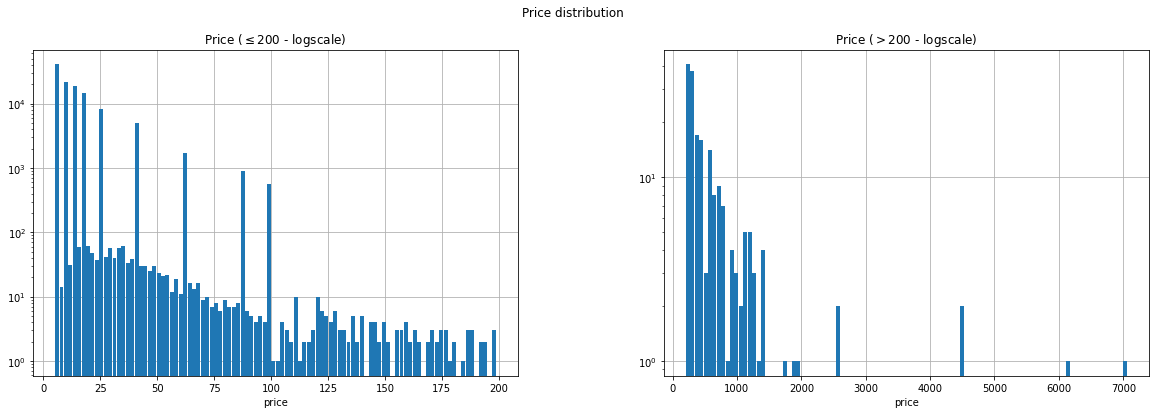

In [9]:
s = 200
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = [20,6])
df_train[df_train['prix_m']<= s].hist(column='prix_m', grid=True, zorder=2, bins=100, rwidth=0.9, ax=ax1, log=True)
df_train[df_train['prix_m']> s].hist(column='prix_m', grid=True, zorder=2, bins=100, rwidth=0.9, ax=ax2, log=True)
plt.suptitle('Price distribution')
ax1.set_title('Price ($\leq {}$ - logscale)'.format(s))
ax2.set_title('Price ($> {}$ - logscale)'.format(s))
ax1.set_xlabel('price')
ax2.set_xlabel('price')
plt.show()

For the rest of the section we will compare the distribution of each quantile to the other feature to find possible correlation between variable which can explain the price.

Here is a preview of some comparaisons, we can suppose there is no obvious correlation, so we will dive into details.

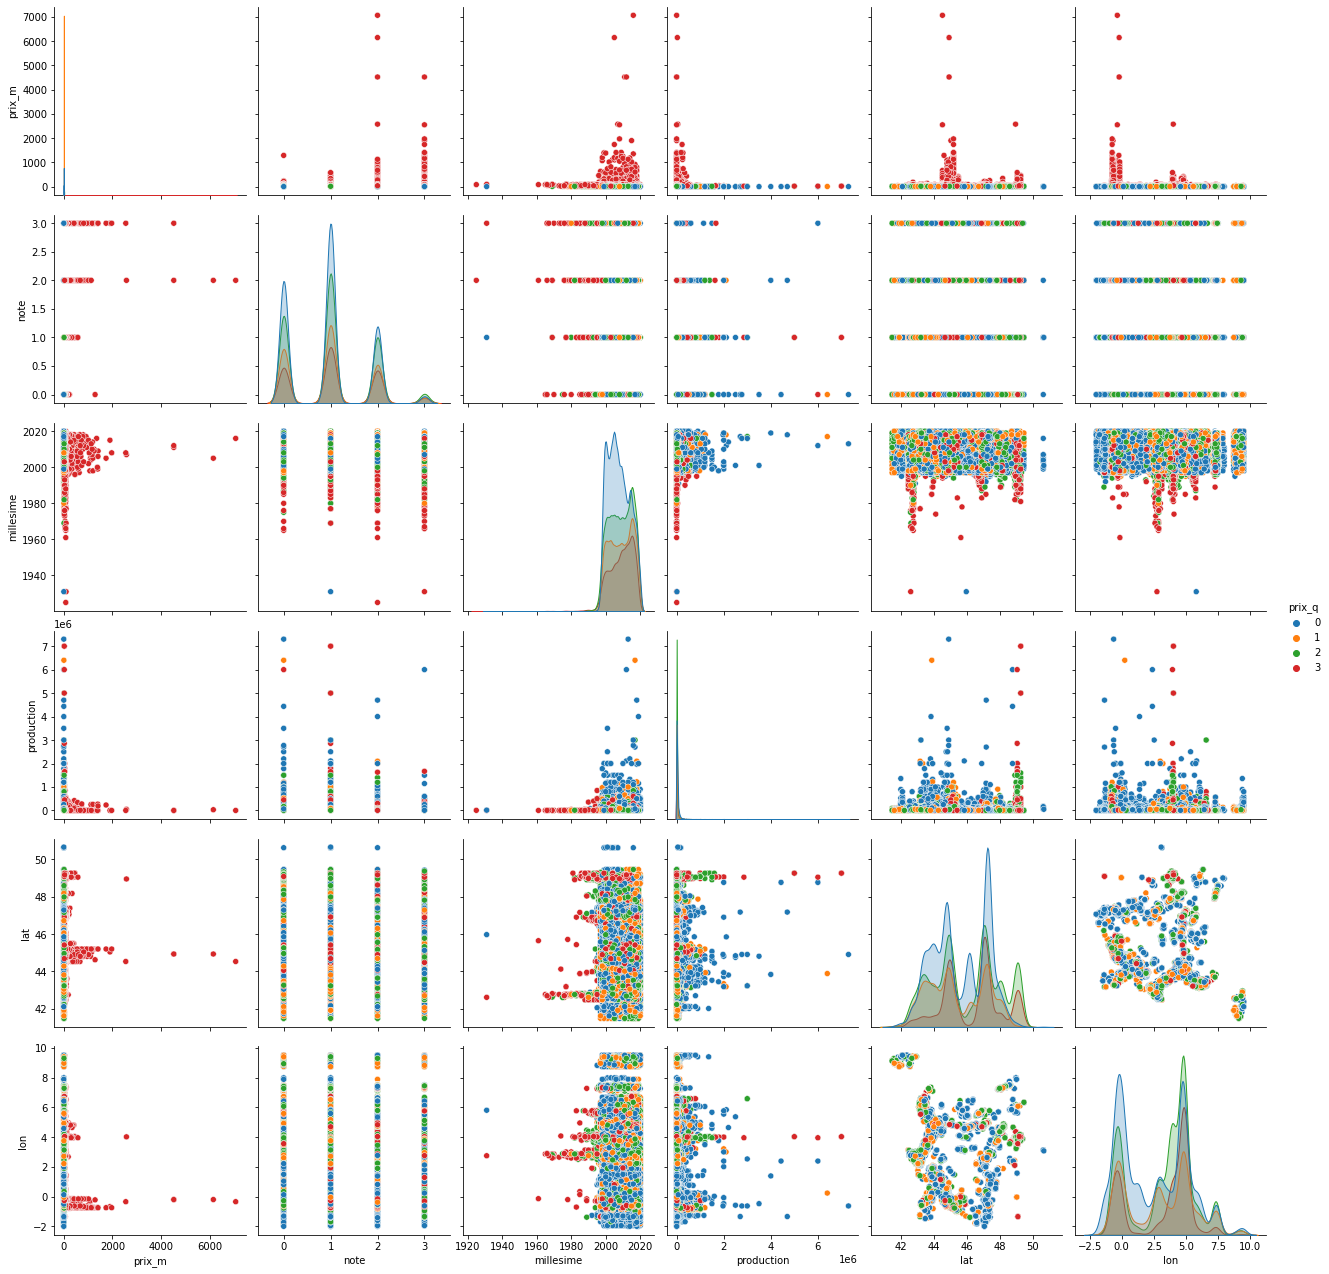

In [10]:
sns.pairplot(df_train, hue='prix_q', vars=['prix_m', 'note', 'millesime', 'production','lat', 'lon'], height=3, palette='tab10')
plt.show()

### Location.

A geographical distribution of the prices.

![map2](img/carte_prix-cat.jpg)

In [11]:
# To generate the interactive map, execute the code below
# %load source/carte_prix-cat.py

![map2](img/carte_prix.jpg)

In [12]:
# To generate the interactive map, execute the code below
# %load source/carte_prix.py

### Note.

There are some wine that are not rated, by default the rating is 0. So there is some biais in the correlation.

Due to the strong inequality in the distribution of the scores, especially in the case of the score 3 which is very little awarded, we cannot conclude whether or not there is a correlation between the score and the price.
However we have similarity between note 0,1,2.

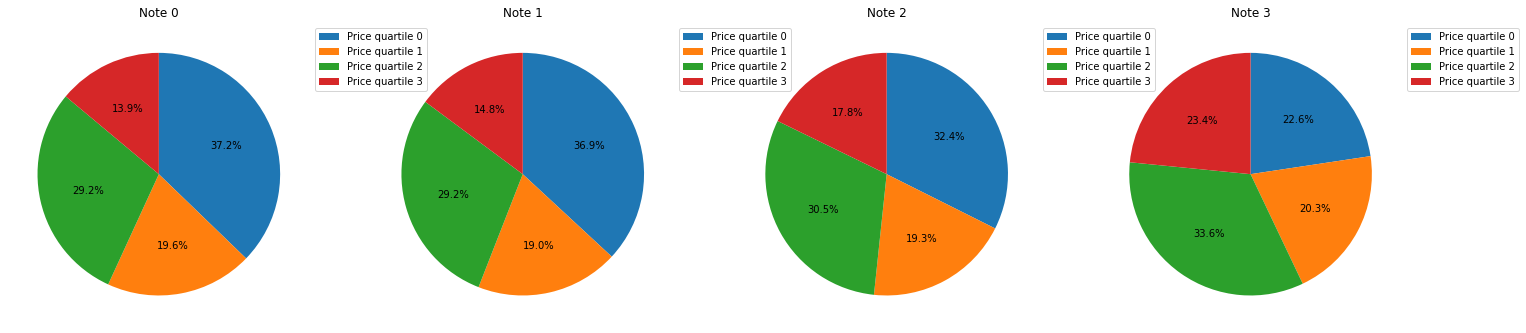

In [13]:
ncol = 4
col = 'note'
l = df_train[df_train[col].notna()][col].unique()
sh = (int(np.ceil(len(l) / ncol)), ncol)
colordict = {'0': plt.cm.tab10(0), '1': plt.cm.tab10(1), '2': plt.cm.tab10(2), '3': plt.cm.tab10(3)}
fig = plt.figure(figsize =(25,7))
for i, reg in enumerate(np.sort(l)):
    ax = fig.add_subplot(sh[0], sh[1], i+1)
    pos = np.unravel_index(i, sh)
    x = df_train[df_train[col]==reg]['prix_q'].value_counts().sort_index()
    wedges = ax.pie(x=x,
                    labels=x.index,
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=False,
                    labeldistance=None,
                    counterclock=False)
    ax.set_title('Note {}'.format(reg))  
    for pie_wedge in wedges[0]:
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
    ax.legend(['Price quartile {}'.format(label) for label in x.index], bbox_to_anchor=(1,1))
plt.show()

### Millésime

Let's study if Millésime is linked to the price, on the graph below we can suppose so, mainly because of the low number of 3 in quantile doesn't allow a proper distribution for this category.
Once again we stil have similarity between note 1 and 2.

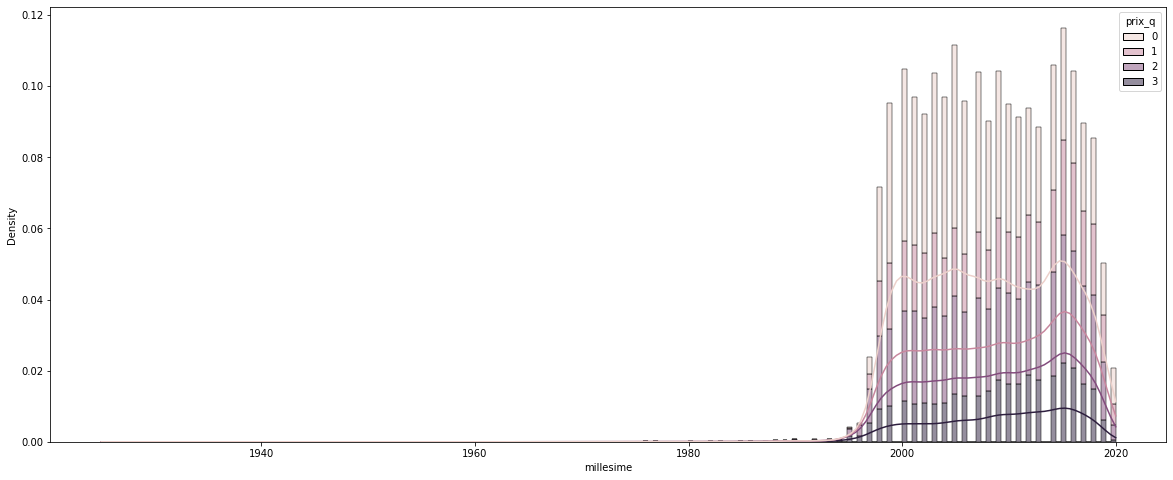

In [14]:
plt.figure(figsize = [20,8])
sns.histplot(data=df_train, x='millesime', hue='prix_q', multiple='stack', stat='density', common_norm=True, kde=True)
plt.show()

#### Regions

Are regions represented uniformaly between the different prices ? There are not as we can see below so we suppose that region are linked to rating.

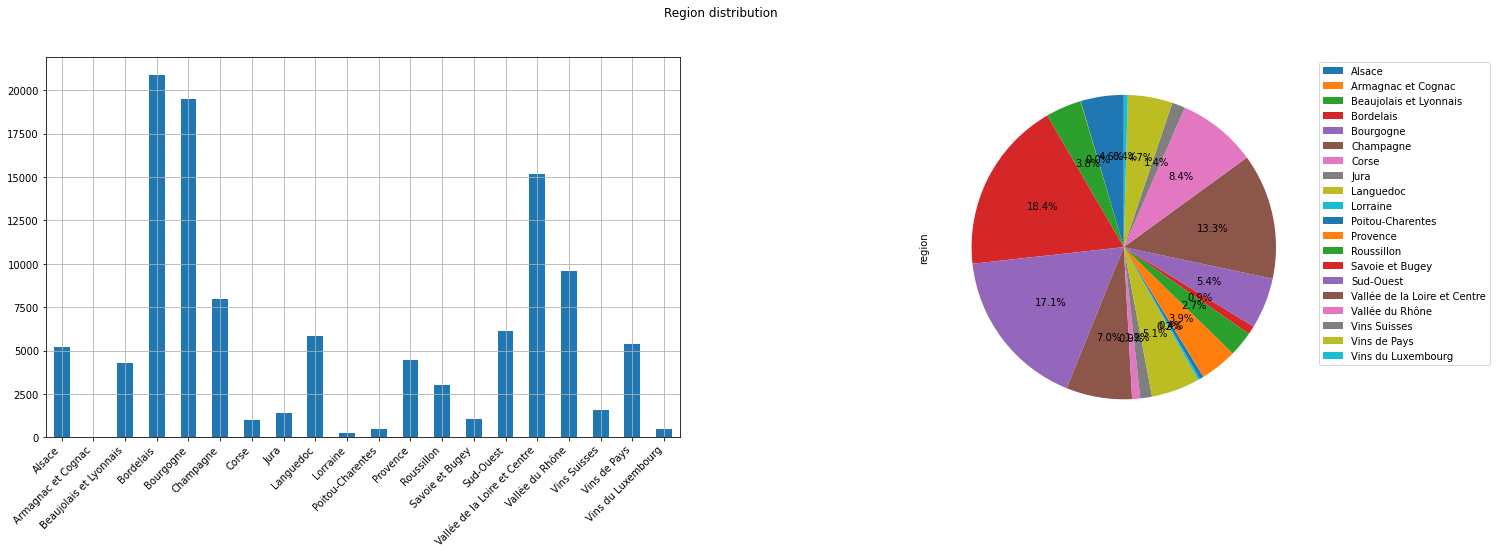

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(25, 7))
_ = df_train['region'].value_counts().sort_index()
_.plot(kind='bar', ax=ax[0])
_.plot(kind='pie',autopct='%1.1f%%', startangle=90, shadow=False, ax=ax[1], labeldistance=None)
ax[1].legend(bbox_to_anchor=(1,1))
l = ax[0].get_xticklabels()
ax[0].grid()
ax[0].set_xticklabels(labels=l, rotation=45, ha='right')
fig.suptitle('Region distribution')
plt.show()

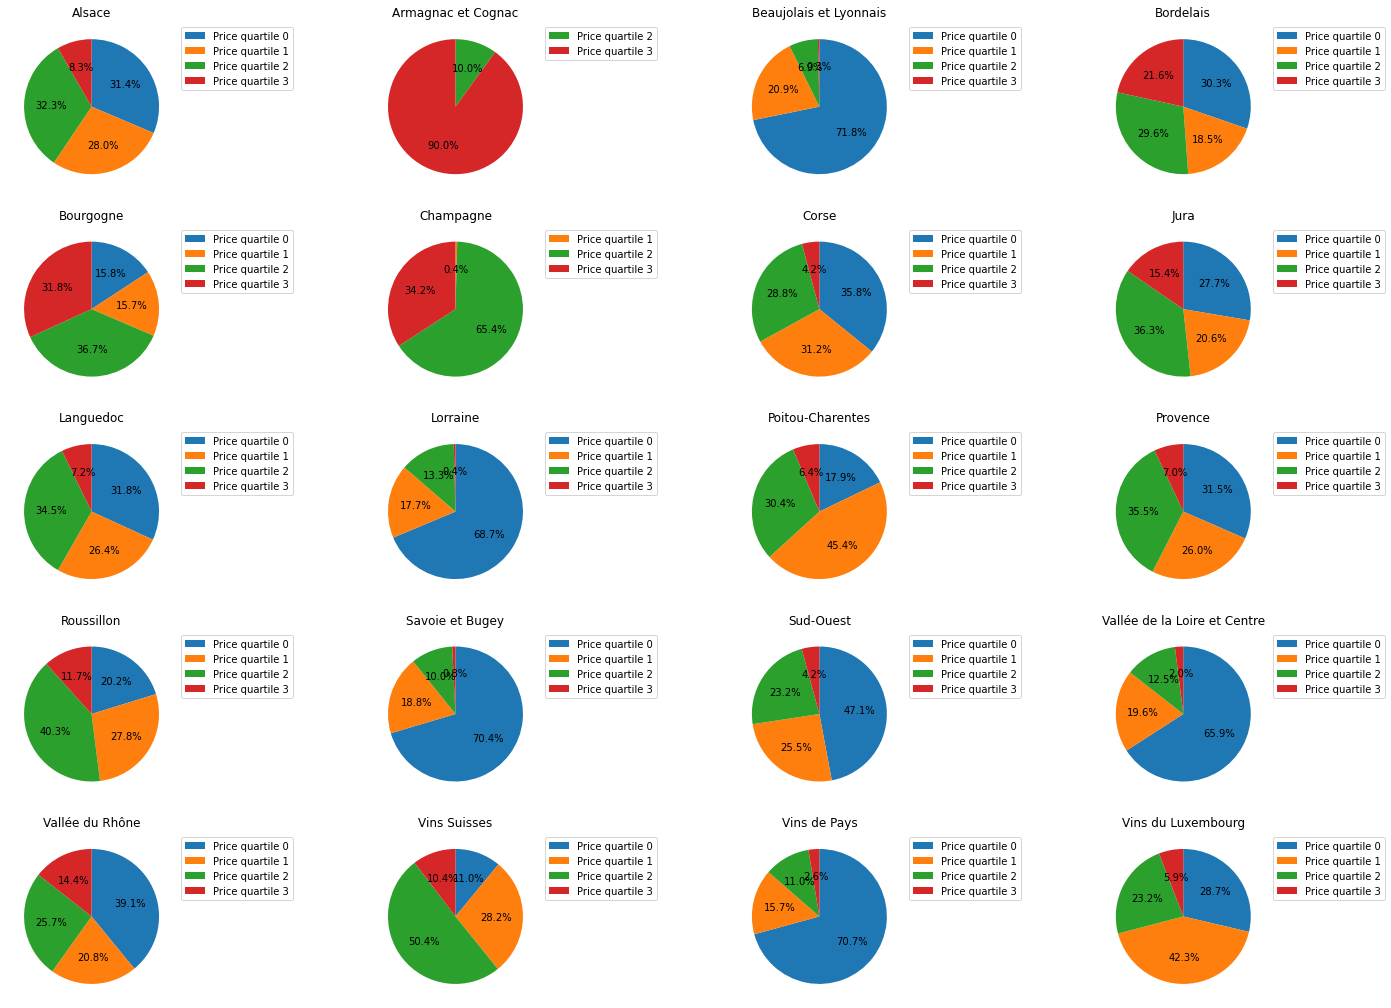

In [16]:
ncol = 4
col = 'region'
l = df_train[df_train[col].notna()][col].unique()
sh = (int(np.ceil(len(l) / ncol)), ncol)
colordict = {'0': plt.cm.tab10(0), '1': plt.cm.tab10(1), '2': plt.cm.tab10(2), '3': plt.cm.tab10(3)}
fig = plt.figure(figsize =(25,18))
for i, reg in enumerate(np.sort(l)):
    ax = fig.add_subplot(sh[0], sh[1], i+1)
    pos = np.unravel_index(i, sh)
    x = df_train[df_train[col]==reg]['prix_q'].value_counts().sort_index()
    wedges = ax.pie(x=x,
                    labels=x.index,
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=False,
                    labeldistance=None,
                    counterclock=False)
    ax.set_title(reg)  
    for pie_wedge in wedges[0]:
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
    ax.legend(['Price quartile {}'.format(label) for label in x.index], bbox_to_anchor=(1,1))
plt.show()

It is also interesting to look at the positioning of each region in the production of wines in a given price range. Thus, we notice that the Champagne region is very well represented in the highest quartiles (probably because of its eponymous sparkling wine), while much less present in the first price quartiles.

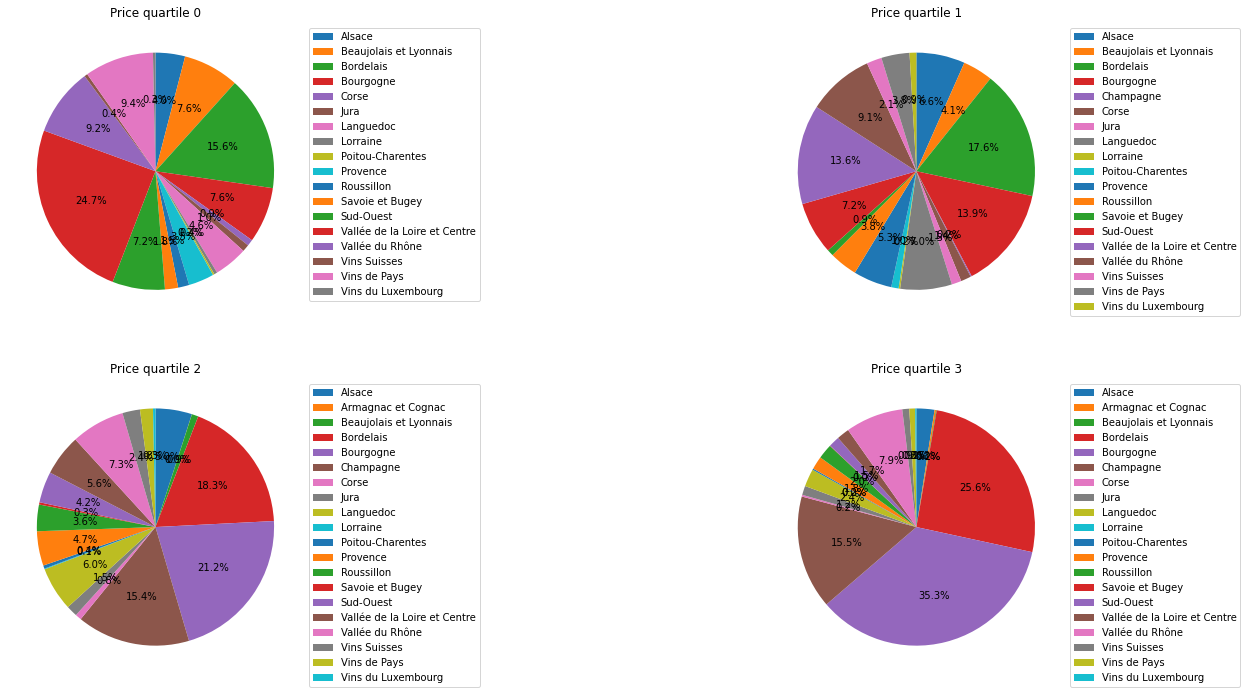

In [17]:
ncol = 4
col = 'region'
sh = (2, 2)
fig = plt.figure(figsize =(25,12))
for i in range(4):
    ax = fig.add_subplot(sh[0], sh[1], i+1)
    x = df_train[df_train['prix_q']==i][col].value_counts().sort_index()
    wedges = ax.pie(x=x,
                    labels=x.index,
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=False,
                    labeldistance=None,
                    counterclock=False)
    ax.set_title('Price quartile {}'.format(i))
    ax.legend(bbox_to_anchor=(1,1))
plt.show()

### Type

Let's look at the type of wine we have (rouge (blanc, rosé) tranquille (effervescent).
And this time it seems that the type is not a creterion for the price.

We notice there is only one "rouge effervescent".

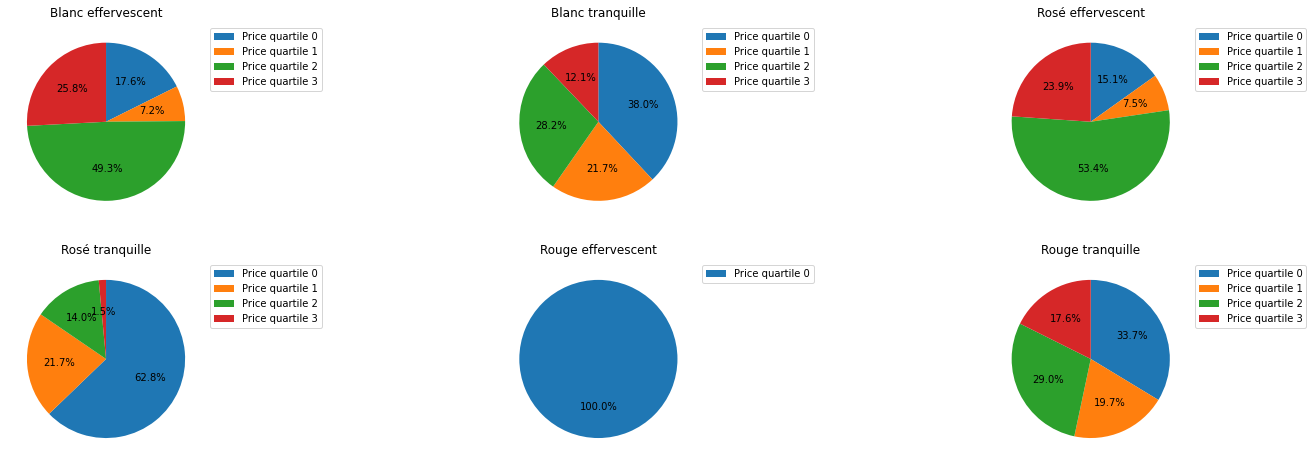

In [18]:
ncol = 3
col = 'type'
l = df_train[df_train[col].notna()][col].unique()
sh = (int(np.ceil(len(l) / ncol)), ncol)
colordict = {'0': plt.cm.tab10(0), '1': plt.cm.tab10(1), '2': plt.cm.tab10(2), '3': plt.cm.tab10(3)}
fig = plt.figure(figsize =(25,8))
for i, reg in enumerate(np.sort(l)):
    ax = fig.add_subplot(sh[0], sh[1], i+1)
    pos = np.unravel_index(i, sh)
    x = df_train[df_train[col]==reg]['prix_q'].value_counts().sort_index()
    wedges = ax.pie(x=x,
                    labels=x.index,
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=False,
                    labeldistance=None,
                    counterclock=False)
    ax.set_title(reg)  
    for pie_wedge in wedges[0]:
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
    ax.legend(['Price quartile {}'.format(label) for label in x.index], bbox_to_anchor=(1,1))
plt.show()

We can see that the distribution of "rouge tranquille" keeps increasing as the price enchances. In other words, there is a strong link between price and type.

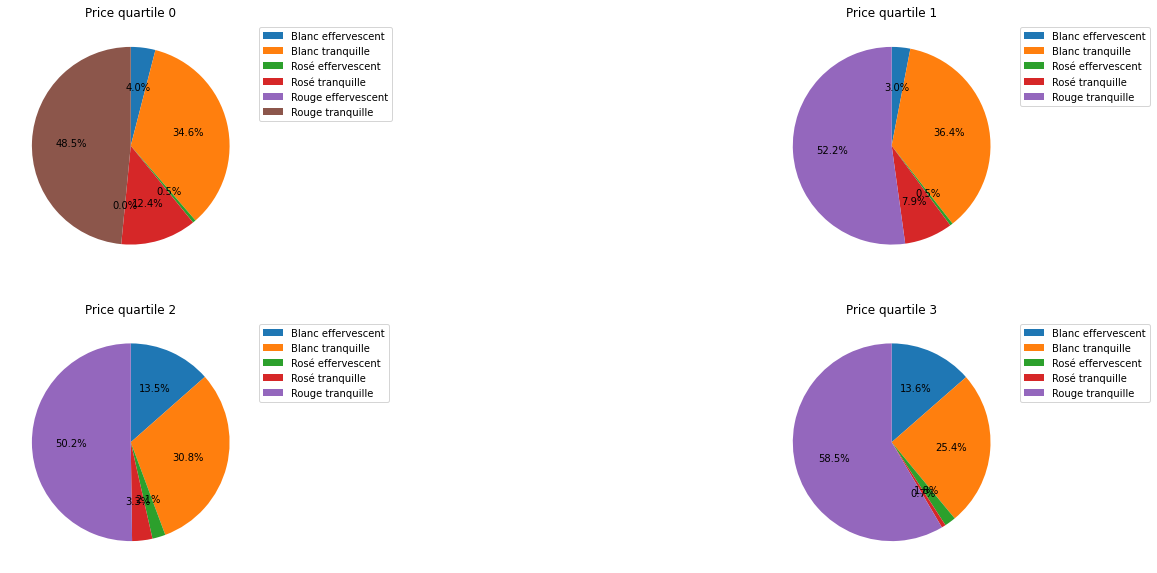

In [19]:
ncol = 4
col = 'type'
sh = (2, 2)
fig = plt.figure(figsize =(25,10))
for i in range(4):
    ax = fig.add_subplot(sh[0], sh[1], i+1)
    x = df_train[df_train['prix_q']==i][col].value_counts().sort_index()
    wedges = ax.pie(x=x,
                    labels=x.index,
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=False,
                    labeldistance=None,
                    counterclock=False)
    ax.set_title('Price quartile {}'.format(i))
    ax.legend(bbox_to_anchor=(1,1))
plt.show()

### Consommation

Consommation is : {'A boire', 'A boire ou garder', 'A garder', nan}

The consomation is non avoidable to predict the price as we can see there : 

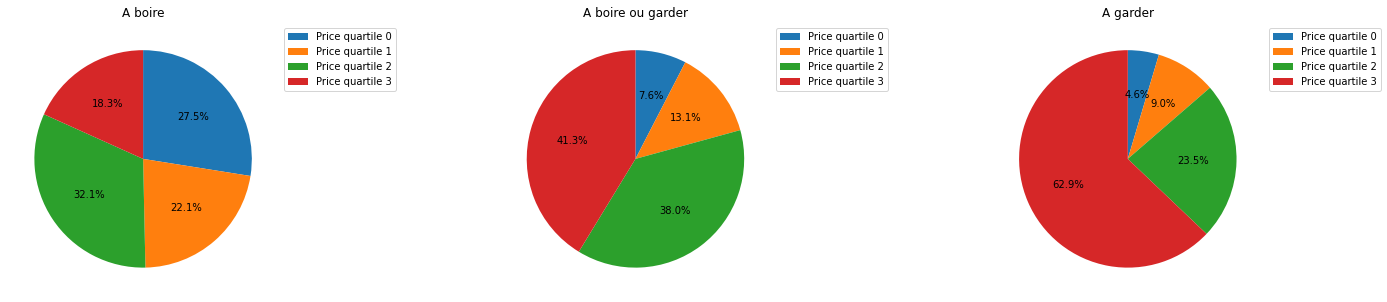

In [20]:
ncol = 3
col = 'consommation'
l = df_train[df_train[col].notna()][col].unique()
sh = (int(np.ceil(len(l) / ncol)), ncol)
colordict = {'0': plt.cm.tab10(0), '1': plt.cm.tab10(1), '2': plt.cm.tab10(2), '3': plt.cm.tab10(3)}
fig = plt.figure(figsize =(25,5))
for i, reg in enumerate(np.sort(l)):
    ax = fig.add_subplot(sh[0], sh[1], i+1)
    pos = np.unravel_index(i, sh)
    x = df_train[df_train[col]==reg]['prix_q'].value_counts().sort_index()
    wedges = ax.pie(x=x,
                    labels=x.index,
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=False,
                    labeldistance=None,
                    counterclock=False)
    ax.set_title(reg)  
    for pie_wedge in wedges[0]:
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
    ax.legend(['Price quartile {}'.format(label) for label in x.index], bbox_to_anchor=(1,1))
plt.show()

For example, a expensive wine is more likely to be "A garder". We can even noticed that the distribution of "A garder" keeps increasing as the price enchances.

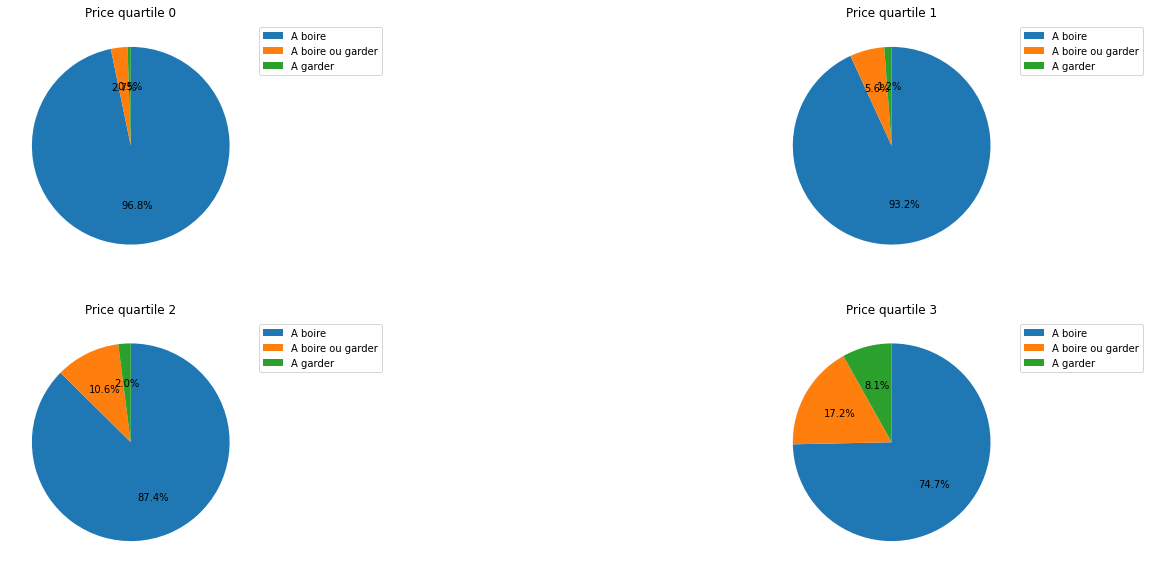

In [21]:
ncol = 4
col = 'consommation'
sh = (2, 2)
fig = plt.figure(figsize =(25,10))
for i in range(4):
    ax = fig.add_subplot(sh[0], sh[1], i+1)
    x = df_train[df_train['prix_q']==i][col].value_counts().sort_index()
    wedges = ax.pie(x=x,
                    labels=x.index,
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=False,
                    labeldistance=None,
                    counterclock=False)
    ax.set_title('Price quartile {}'.format(i))
    ax.legend(bbox_to_anchor=(1,1))
plt.show()

# Classement

The classement are : 
{'1e cat.',
 '1er cru',
 '1er cru clas.',
 '1er cru clas. sup.',
 '1er gd cru clas',
 '1er gd cru clas. A',
 '1er gd cru clas. B',
 '2e cru clas.',
 '3e cru clas.',
 '4e cru clas.',
 '5e cru clas.',
 'Cru artisan',
 'Cru bourg.',
 'Cru clas.',
 'Gd 1er cru',
 'Gd cru',
 'Gd cru clas.',
 nan}

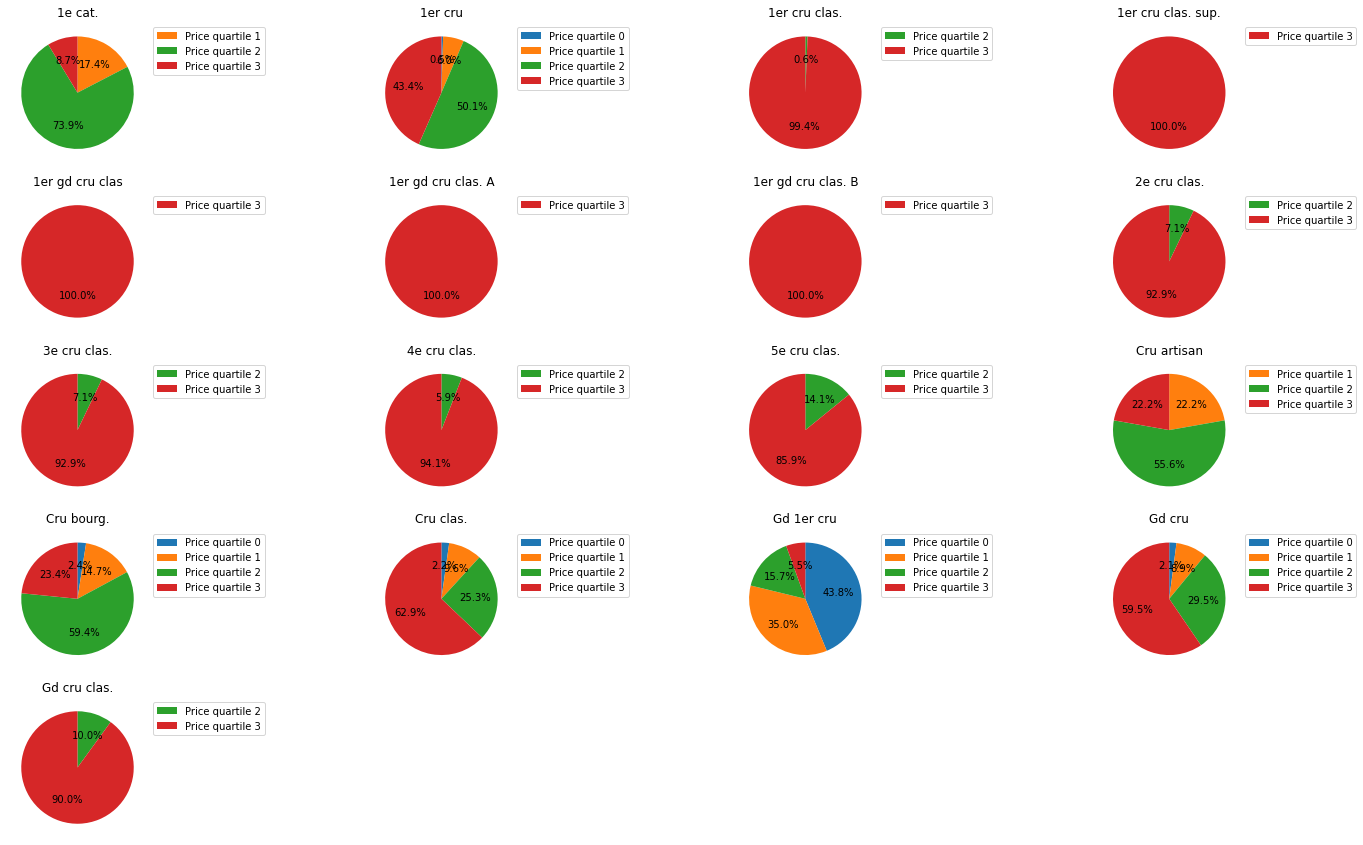

In [22]:
ncol = 4
col = 'classement'
l = df_train[df_train[col].notna()][col].unique()
sh = (int(np.ceil(len(l) / ncol)), ncol)
colordict = {'0': plt.cm.tab10(0), '1': plt.cm.tab10(1), '2': plt.cm.tab10(2), '3': plt.cm.tab10(3)}
fig = plt.figure(figsize =(25,15))
for i, reg in enumerate(np.sort(l)):
    ax = fig.add_subplot(sh[0], sh[1], i+1)
    pos = np.unravel_index(i, sh)
    x = df_train[df_train[col]==reg]['prix_q'].value_counts().sort_index()
    wedges = ax.pie(x=x,
                    labels=x.index,
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=False,
                    labeldistance=None,
                    counterclock=False)
    ax.set_title(reg)  
    for pie_wedge in wedges[0]:
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
    ax.legend(['Price quartile {}'.format(label) for label in x.index], bbox_to_anchor=(1,1))
plt.show()

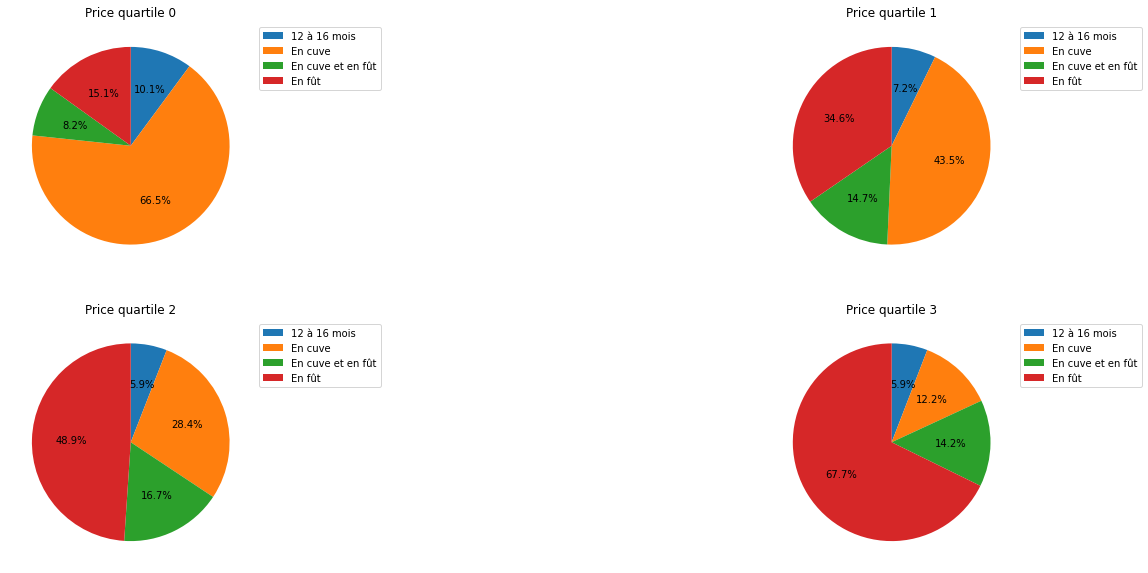

In [23]:
ncol = 4
col = 'elevage'
sh = (2, 2)
fig = plt.figure(figsize =(25,10))
for i in range(4):
    ax = fig.add_subplot(sh[0], sh[1], i+1)
    x = df_train[df_train['prix_q']==i][col].value_counts().sort_index()
    wedges = ax.pie(x=x,
                    labels=x.index,
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=False,
                    labeldistance=None,
                    counterclock=False)
    ax.set_title('Price quartile {}'.format(i))
    ax.legend(bbox_to_anchor=(1,1))
plt.show()

The classement is relevant to study rating 

# Elevage

This one is difficult, it seems that if you are a "en cuve et en fût" you are less likely to get a 3 as a rating. So rating depends on Elevage.

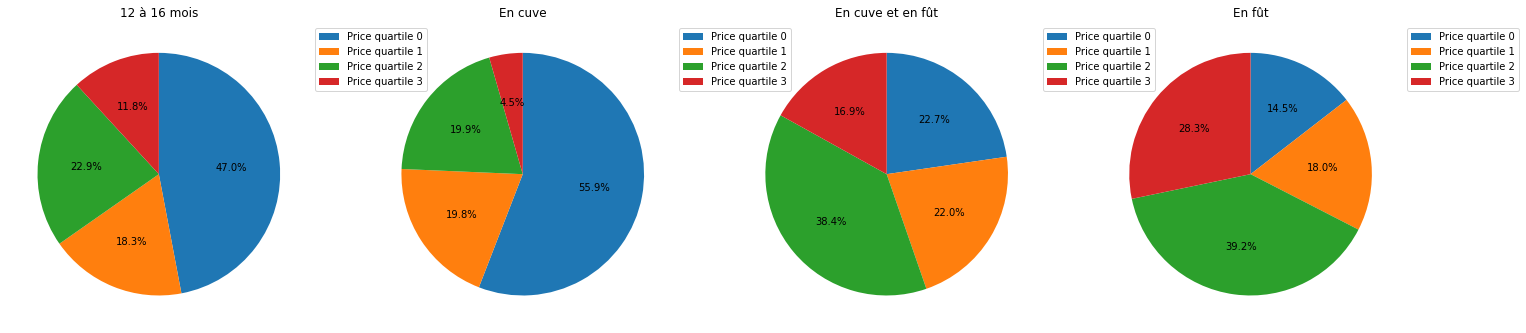

In [24]:
ncol = 4
col = 'elevage'
l = df_train[df_train[col].notna()][col].unique()
sh = (int(np.ceil(len(l) / ncol)), ncol)
colordict = {'0': plt.cm.tab10(0), '1': plt.cm.tab10(1), '2': plt.cm.tab10(2), '3': plt.cm.tab10(3)}
fig = plt.figure(figsize =(25,7))
for i, reg in enumerate(np.sort(l)):
    ax = fig.add_subplot(sh[0], sh[1], i+1)
    pos = np.unravel_index(i, sh)
    x = df_train[df_train[col]==reg]['prix_q'].value_counts().sort_index()
    wedges = ax.pie(x=x,
                    labels=x.index,
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=False,
                    labeldistance=None,
                    counterclock=False)
    ax.set_title(reg)  
    for pie_wedge in wedges[0]:
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
    ax.legend(['Price quartile {}'.format(label) for label in x.index], bbox_to_anchor=(1,1))
plt.show()

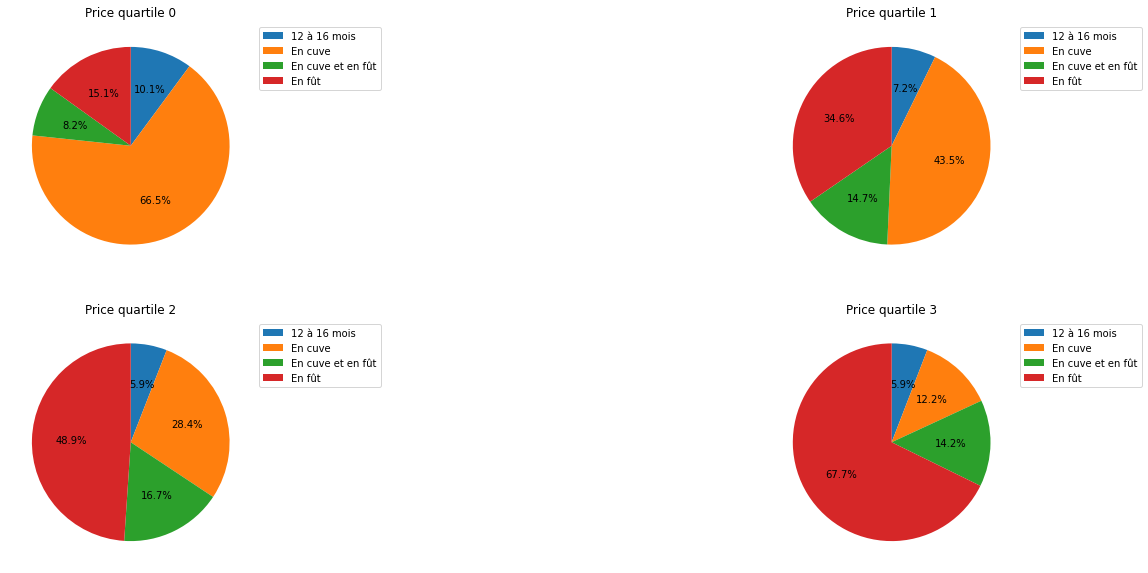

In [25]:
ncol = 4
col = 'elevage'
sh = (2, 2)
fig = plt.figure(figsize =(25,10))
for i in range(4):
    ax = fig.add_subplot(sh[0], sh[1], i+1)
    x = df_train[df_train['prix_q']==i][col].value_counts().sort_index()
    wedges = ax.pie(x=x,
                    labels=x.index,
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=False,
                    labeldistance=None,
                    counterclock=False)
    ax.set_title('Price quartile {}'.format(i))
    ax.legend(bbox_to_anchor=(1,1))
plt.show()

### Conclusion

We didn't look at the variables : cuvee, appellation, production, producteur du to a lack of data as this variables have a great number of possiblities.

For the rest of the variable, we figured out that the type of wine is not relevant to study the rating. 

# Basic model.

## Train set preparation.

In [26]:
df_train = pd.read_csv('data/train.csv', sep=';', encoding='utf-8')

# Elimination des vins dont on ne dispose pas du millesime ou du prix
df_train = df_train[~df_train['millesime'].isna()].reset_index(drop=True)

Y_train = df_train[['prix_m']].copy()

# Elimination de certaines colonnes
X_train = df_train.drop(columns=['guide', 'prix',
                                 'prix_min', 'prix_max', 'prix_m',
                                 'garde', 'cuvee',
                                 'prod_id',
                                 'adresse', 'CP', 'commune', 'pays',
                                 'INSEE_COM', 'INSEE_DEP', 'INSEE_REG'])

## Test set preparation.

In [27]:
df_test = pd.read_csv('data/test.csv', sep=';', encoding='utf-8')

# Elimination des vins dont on ne dispose pas du millesime ou du prix
df_test = df_test[~df_test['millesime'].isna()].reset_index(drop=True)

Y_test = df_test[['prix_m']].copy()

# Elimination de certaines colonnes
X_test = df_test.drop(columns=['guide', 'prix',
                               'prix_min', 'prix_max', 'prix_m',
                               'garde', 'cuvee',
                               'prod_id',
                               'adresse', 'CP', 'commune', 'pays',
                               'INSEE_COM', 'INSEE_DEP', 'INSEE_REG'])

## Model definition.

In [28]:
ohe_cols = ['classement', 'region', 'commentaire', 'type', 'consommation', 'elevage']
tgt_cols = ['vin', 'producteur', 'appellation']

In [29]:
ohe_pipeline = Pipeline([
    #("imputer", SimpleImputer(strategy='constant', fill_value='missing')),
    ("one-hot-encoder", OneHotEncoder(handle_unknown='ignore'))
])

tgt_pipeline = Pipeline([
    ("target-encoder", ce.TargetEncoder())
])

preprocessing = ColumnTransformer([
    ("ohe_preproc", ohe_pipeline, ohe_cols),
    ("tgt_preproc", tgt_pipeline, tgt_cols)
])

model = Pipeline([
    ("Preprocessing", preprocessing),
    ("regressor", LinearRegression())
])
model.fit(X_train, Y_train)

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('ohe_preproc',
                                                  Pipeline(steps=[('one-hot-encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['classement', 'region',
                                                   'commentaire', 'type',
                                                   'consommation', 'elevage']),
                                                 ('tgt_preproc',
                                                  Pipeline(steps=[('target-encoder',
                                                                   TargetEncoder())]),
                                                  ['vin', 'producteur',
                                                   'appellation'])])),
                ('regressor', LinearRegression())])

In [30]:
from sklearn.metrics import mean_absolute_percentage_error

In [31]:
Y_train_hat = model.predict(X_train)
mean_absolute_percentage_error(Y_train, Y_train_hat)

0.3450056529856495

In [32]:
Y_test_hat = model.predict(X_test)
mean_absolute_percentage_error(Y_test, Y_test_hat)

0.39134417470696803